# Comparison of algortihms/ansatz in Li-H ground state search
## VQE
## AdaptVQE
## VHA
## Imaginary time evolution

##

In [1]:
#%%pycodestyle
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.algorithms import VQEUCCFactory,GroundStateEigensolver,AdaptVQE
from qiskit_nature.circuit.library import HartreeFock

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP,L_BFGS_B,SPSA
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit.circuit.library import TwoLocal
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator,QasmSimulator


from qiskit_mod.qiskit_nat import VHA
from qiskit_mod.qiskit_ter import LinCombFullmod,LinCombMod

import numpy as np 
import time as time
import matplotlib.pyplot as plt

#CHECK VERSIONS OF QISKIT: 'qiskit-terra': '0.19.0','qiskit-aer': '0.8.2','qiskit-nature': '0.2.0'
import qiskit
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.18.2', 'qiskit-aer': '0.9.0', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.16.0', 'qiskit-aqua': '0.9.5', 'qiskit': '0.30.0', 'qiskit-nature': '0.2.0', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


/home/gsilvi/miniforge3/envs/NEASQC4featMYQLM/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [29]:
# %%pycodestyle
distances = np.arange(1, 5, 1)  # angstrom distance


# Initialize qubit converter
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)  # two qubit reduction doesn`t work with Jordan-WignerMapper()

# Initialize Exact solvers & VQE solver
numpy_solver = NumPyMinimumEigensolver()


# NOISE
seed = 170
usenoise=True  #HERE CHOOSE TO USE THE NOISE 
backend = Aer.get_backend('aer_simulator')
if usenoise:
    
    device_backend = FakeVigo()
    device = QasmSimulator.from_backend(device_backend)
    coupling_map = device.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device)
    basis_gates = noise_model.basis_gates
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)
else:
    quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))



# Optimizer
optimizer = L_BFGS_B(maxiter=1000)
#optimizer = SPSA(maxiter=100)


# vha solver
trotter_steps = 3
time_step_size = 1.
# prepare intial point for VHA, inspired by adiabatic evolution
ip = []
for i in range(trotter_steps):
    ip.append(time_step_size*((i+1)/trotter_steps))  # param for H_ex = V
    ip.append(time_step_size)                        # param for H_hop = H_0
    ip.append(time_step_size)                        # param for H_diag = H_0
print('Initial parameter for VHA, '+str(trotter_steps)+'*(H_ex,H_op,H_diag)=', ip)



Initial parameter for VHA, 3*(H_ex,H_op,H_diag)= [0.3333333333333333, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0]


In [30]:
#%%pycodestyle

exact_energies, hf_energies, vqe_energies, adapt_vqe_energies, Ievo_energies, Ievo_params, vqe_params, adapt_vqe_params, vha_energies, vha_params = ([] for i in range(10))

# Molecule
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'


for i, bond_distance in enumerate(distances):  # loop over distances
    print('\n step', i, ', bond_distance=', bond_distance)
    
    driver = PySCFDriver(atom=molecule.format(bond_distance/2), unit=UnitsType.ANGSTROM, basis='sto3g')
    qmolecule = driver.run()
    es_problem = ElectronicStructureProblem(driver,q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4,5])])
    second_q_op = es_problem.second_q_ops()
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles) #this line is useful for initialize the converter and get the right hartree-fock number of qubits
    
    particle_number = es_problem.properties_transformed.get_property("ParticleNumber")
    num_particles = (particle_number.num_alpha, particle_number.num_beta)
    num_spin_orbitals = particle_number.num_spin_orbitals

    # Initialize solvers
    
    # Imag. Evo/ Natural gradient solver
    hartree_fock_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
    print('Number of qubits',hartree_fock_state.num_qubits)
    nat_grad = NaturalGradient(grad_method=LinCombMod(img=False), qfi_method=LinCombFullmod(), regularization='ridge')
    ansz = TwoLocal(4, rotation_blocks=['ry'],  entanglement_blocks='cx', entanglement="full", reps=1, parameter_prefix='a', initial_state=hartree_fock_state)
    Im_solver = VQEUCCFactory(quantum_instance, gradient=nat_grad,optimizer=optimizer, ansatz=ansz.decompose())
    calcIevo = GroundStateEigensolver(qubit_converter, Im_solver)

    # vha solver
    vha_solver = VQEUCCFactory(quantum_instance, optimizer=optimizer, initial_point=np.asarray(ip), ansatz=VHA(excitations='sd', trotter_steps=trotter_steps, only_excitations=True))
    calcVHA = GroundStateEigensolver(qubit_converter, vha_solver)

    # vqe solver
    vqe_solver = VQEUCCFactory(quantum_instance, optimizer=optimizer)
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)

    # adapt vqe solver
    adapt_calc = AdaptVQE(qubit_converter, vqe_solver, threshold=0.001)

    # exact numpy solver
    exact_calc = GroundStateEigensolver(qubit_converter, numpy_solver)

    # Run the computation
    # compute ground state with Imaginary time evo 
    start = time.time()
    resIevo = calcIevo.solve(es_problem)
    Ievo_energies.append(np.real(resIevo.total_energies))
    Ievo_params.append(len(resIevo.raw_result.optimal_parameters))
    end = time.time()
    print('Imaginary time evo. ,',
          resIevo.total_energies, ',exec_time=',
          end - start, 's, number of optimal parameters=',
          len(resIevo.raw_result.optimal_parameters))


    # compute ground state with VHA
    start = time.time()
    resVHA = calcVHA.solve(es_problem)
    vha_energies.append(np.real(resVHA.total_energies))
    vha_params.append(len(resVHA.raw_result.optimal_parameters))
    end = time.time()
    print('VHA ,', trotter_steps, 'steps:',
          resVHA.total_energies, ',exec_time=',
          end - start, 's, number of optimal parameters=',
          len(resVHA.raw_result.optimal_parameters))

    # compute ground state with VQE
    start = time.time()
    res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies))
    hf_energies.append(res.hartree_fock_energy)
    vqe_params.append(len(res.raw_result.optimal_parameters))
    end = time.time()
    print('VQE:\t', res.total_energies,
          ',exec_time=', end - start,
          's, number of optimal parameters=', len(res.raw_result.optimal_parameters))

    # compute ground state with AdaptVQE
    start = time.time()
    res2 = adapt_calc.solve(es_problem)
    adapt_vqe_energies.append(np.real(res2.total_energies))
    adapt_vqe_params.append(len(res2.raw_result.optimal_parameters))
    end = time.time()
    print('AdaptVQE:', res2.total_energies,
          ',exec_time=', end - start,
          's, number of iterations', res2._num_iterations,
          ',number of optimal parameters=', len(res2.raw_result.optimal_parameters),
          '\n(final max gradient', res2._final_max_gradient,
          'final criterion', res2._finishing_criterion, ')')

    # compute exact ground state
    start = time.time()
    res3 = exact_calc.solve(es_problem)
    exact_energies.append(res3.total_energies)
    end = time.time()
    print('Exact:\t', res3.total_energies, ',exec_time=', end - start, 's')


 step 0 , bond_distance= 1
Number of qubits 4


The measured number of particles 2.326171874999999 does NOT match the expected number of particles 2!


Imaginary time evo. , [-7.67616855+0.j] ,exec_time= 1475.4567923250015 s, number of optimal parameters= 8


The measured number of particles 2.9628906249999996 does NOT match the expected number of particles 2!


VHA , 3 steps: [-7.20577219+0.j] ,exec_time= 21.536314429999038 s, number of optimal parameters= 9


The measured number of particles 2.255859374999999 does NOT match the expected number of particles 2!


VQE:	 [-7.41082013+0.j] ,exec_time= 8.649396623999564 s, number of optimal parameters= 8


The measured number of particles 2.285156249999999 does NOT match the expected number of particles 2!


AdaptVQE: [-7.50258812+0.j] ,exec_time= 283.59936626700073 s, number of iterations 8 ,number of optimal parameters= 7 
(final max gradient 0.017598166198293685 final criterion Aborted due to cyclicity )
Exact:	 [-7.76862177+0.j] ,exec_time= 4.664599748999535 s

 step 1 , bond_distance= 2
Number of qubits 4


The measured number of particles 2.2441406249999987 does NOT match the expected number of particles 2!


Imaginary time evo. , [-7.72741138+0.j] ,exec_time= 1259.5062518820014 s, number of optimal parameters= 8


The measured number of particles 2.9628906249999996 does NOT match the expected number of particles 2!


VHA , 3 steps: [-7.27132429+0.j] ,exec_time= 23.015835305999644 s, number of optimal parameters= 9


The measured number of particles 2.255859374999999 does NOT match the expected number of particles 2!


VQE:	 [-7.48194811+0.j] ,exec_time= 11.645178235999992 s, number of optimal parameters= 8


The measured number of particles 2.308593749999999 does NOT match the expected number of particles 2!


AdaptVQE: [-7.50302675+0.j] ,exec_time= 464.43932306499846 s, number of iterations 11 ,number of optimal parameters= 10 
(final max gradient 0.03095341741641966 final criterion Aborted due to cyclicity )
Exact:	 [-7.83222196+0.j] ,exec_time= 1.7949349890004669 s

 step 2 , bond_distance= 3
Number of qubits 4


The measured number of particles 2.1972656249999987 does NOT match the expected number of particles 2!


Imaginary time evo. , [-7.53726058+0.j] ,exec_time= 986.1509092960005 s, number of optimal parameters= 8


The measured number of particles 2.9628906249999996 does NOT match the expected number of particles 2!


VHA , 3 steps: [-7.24453107+0.j] ,exec_time= 22.254163681001955 s, number of optimal parameters= 9


The measured number of particles 2.255859374999999 does NOT match the expected number of particles 2!


VQE:	 [-7.4229318+0.j] ,exec_time= 8.745533151999553 s, number of optimal parameters= 8


The measured number of particles 2.3300781249999987 does NOT match the expected number of particles 2!


AdaptVQE: [-7.65055308+0.j] ,exec_time= 48.06125761200019 s, number of iterations 2 ,number of optimal parameters= 1 
(final max gradient 0.026886406762874182 final criterion Aborted due to cyclicity )
Exact:	 [-7.72709297+0.j] ,exec_time= 3.311936288002471 s

 step 3 , bond_distance= 4
Number of qubits 4


The measured number of particles 2.1816406249999987 does NOT match the expected number of particles 2!


Imaginary time evo. , [-7.67690817+0.j] ,exec_time= 548.6778985389974 s, number of optimal parameters= 8


The measured number of particles 2.9628906249999996 does NOT match the expected number of particles 2!


VHA , 3 steps: [-7.27388508+0.j] ,exec_time= 21.4274903229998 s, number of optimal parameters= 9


The measured number of particles 2.255859374999999 does NOT match the expected number of particles 2!


VQE:	 [-7.40740331+0.j] ,exec_time= 8.595743882000534 s, number of optimal parameters= 8


The measured number of particles 2.3300781249999987 does NOT match the expected number of particles 2!


AdaptVQE: [-7.58578793+0.j] ,exec_time= 23.844792638003128 s, number of iterations 2 ,number of optimal parameters= 1 
(final max gradient 0.07911431029813326 final criterion Aborted due to cyclicity )
Exact:	 [-7.74939375+0.j] ,exec_time= 1.0066956150003534 s


/home/gsilvi/miniforge3/envs/NEASQC4/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


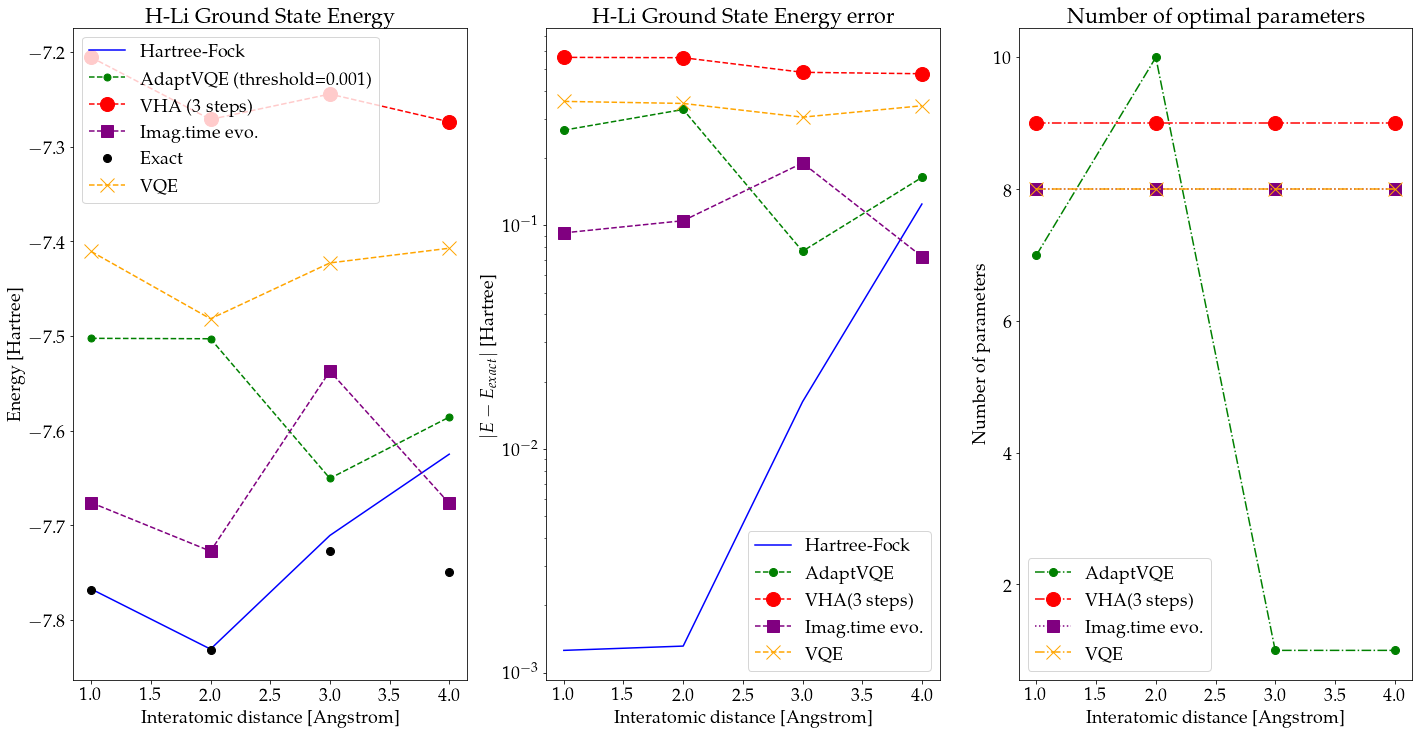

In [32]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Palatino"],
    'font.size'   : 18})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))

ax1.plot(distances, hf_energies, color='blue', label='Hartree-Fock')
ax1.plot(distances, adapt_vqe_energies, '.',markersize=14,linestyle='--', color='green', label='AdaptVQE (threshold=0.001)')
ax1.plot(distances, vha_energies, 'o',markersize=14,linestyle='--', color='red', label='VHA ('+str(trotter_steps)+' steps)')
ax1.plot(distances, Ievo_energies, 's',markersize=12,linestyle='--', color='purple', label='Imag.time evo.')
ax1.plot(distances, exact_energies, '.',markersize=16, color='black', label='Exact')
ax1.plot(distances, vqe_energies, 'x',markersize=14,linestyle='--', color='orange', label='VQE')
ax1.set_xlabel('Interatomic distance [Angstrom]')
ax1.set_ylabel('Energy [Hartree]')
ax1.set_title('H-Li Ground State Energy')
ax1.legend(loc='upper left')


ypoints = [abs(a - b) for a, b in zip(hf_energies, exact_energies)]
ax2.plot(distances, ypoints, color='blue', label='Hartree-Fock')
ypoints = [abs(a - b) for a, b in zip(adapt_vqe_energies, exact_energies)]
ax2.plot(distances, ypoints, '.',markersize=16, linestyle='--', color='green', label='AdaptVQE')
ypoints = [abs(a - b) for a, b in zip(vha_energies, exact_energies)]
ax2.plot(distances, ypoints, 'o',markersize=14, linestyle='--', color='red', label='VHA('+str(trotter_steps)+' steps)')
ypoints = [abs(a - b) for a, b in zip(Ievo_energies, exact_energies)]
ax2.plot(distances, ypoints, 's',markersize=12, linestyle='--', color='purple', label='Imag.time evo.')
ypoints = [abs(a - b) for a, b in zip(vqe_energies, exact_energies)]
ax2.plot(distances, ypoints, 'x',markersize=14, linestyle='--', color='orange', label='VQE')

ax2.set_yscale('log')
ax2.set_xlabel('Interatomic distance [Angstrom]')
ax2.set_ylabel('$|E-E_{exact}|$ [Hartree]')
ax2.set_title('H-Li Ground State Energy error')
ax2.legend()



ax3.plot(distances, adapt_vqe_params, '.',markersize=16, linestyle='-.', color='green', label='AdaptVQE')
ax3.plot(distances, vha_params, 'o',markersize=14, linestyle='-.', color='red', label='VHA('+str(trotter_steps)+' steps)')
ax3.plot(distances, Ievo_params, 's',markersize=12, linestyle=':', color='purple', label='Imag.time evo.')
ax3.plot(distances, vqe_params, 'x',markersize=14, linestyle='-.', color='orange', label='VQE')

ax3.set_xlabel('Interatomic distance [Angstrom]')
ax3.set_ylabel('Number of parameters')
ax3.set_title('Number of optimal parameters')
ax3.legend()


if usenoise==True: fig.savefig('LiH_ground_energy_noise.pdf')
else: fig.savefig('LiH_ground_energy.pdf')